In [0]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 5563 (delta 0), reused 2 (delta 0), pack-reused 5557
Receiving objects: 100% (5563/5563), 13.34 MiB | 15.50 MiB/s, done.
Resolving deltas: 100% (3726/3726), done.


In [0]:
!pip install --upgrade keras

     |████████████████████████████████| 378kB 5.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
%cd keras-retinanet/
!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=170193 sha256=8ae0647126c33555ed7facfc90365a85a7f901a42530164ae848dac918bfcfde
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=1d4543ce8f21556eb9c447bff143f569b2ad31c93cad3585836d287fdbfa8279
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet


In [0]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [0]:
!pip install gdown
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 41kB/s 
     |████████████████████████████████| 450kB 49.2MB/s 
     |████████████████████████████████| 3.8MB 50.7MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [0]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import csv 
import cv2
import urllib

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr , preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box , draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format = "retina"

register_matplotlib_converters()

rcParams['figure.figsize'] = 22,10

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [0]:
!gdown --id 1nKMnDPapTCWIqbISNskwIqsYd4QV87zC --output pur.json

Downloading...
From: https://drive.google.com/uc?id=1nKMnDPapTCWIqbISNskwIqsYd4QV87zC
To: /content/keras-retinanet/pur.json
100% 2.43k/2.43k [00:00<00:00, 12.1MB/s]


In [0]:
os.makedirs("/content/puro" , exist_ok=True)

In [0]:
!unzip /content/dataset.zip -d /content/puro/

Archive:  /content/dataset.zip
  inflating: /content/puro/1.jpeg    
  inflating: /content/puro/2.jpeg    
  inflating: /content/puro/3.jpeg    
  inflating: /content/puro/4.jpeg    
  inflating: /content/puro/5.jpeg    
  inflating: /content/puro/6.jpeg    
  inflating: /content/puro/7.jpeg    
  inflating: /content/puro/8.jpeg    


In [0]:
puro = pd.read_json("pur.json" , lines=True)

In [0]:
dataset = {}
dataset["img_name"] = []
dataset["x_min"] = []
dataset["y_min"] = []
dataset["x_max"] = []
dataset["y_max"] = []
dataset["class_name"] = []

counter = 0

for index , row in puro.iterrows():
  find = row.annotations
  img_total = len(find)
  for x in range(img_total):
      dataset["x_min"].append(round(find[x]["segmentation"][0][0]))
      dataset["y_min"].append(round(find[x]["segmentation"][0][1]))
      dataset["x_max"].append(round(find[x]["segmentation"][0][4]))
      dataset["y_max"].append(round(find[x]["segmentation"][0][5]))
      dataset["img_name"].append(f"/content/puro/{x+1}.jpeg")
      dataset["class_name"].append("puro")

In [0]:
df = pd.DataFrame(dataset)
df.head()

,img_name,x_min,y_min,x_max,y_max,class_name
0,/content/puro/1.jpeg,62,446,336,992,puro
1,/content/puro/2.jpeg,334,335,644,914,puro
2,/content/puro/3.jpeg,150,420,356,894,puro
3,/content/puro/4.jpeg,224,73,577,956,puro
4,/content/puro/5.jpeg,230,248,520,958,puro


In [0]:
def show_img(img_row):
  img_path = "/" + img_row.img_name
  box_coor = [img_row.x_min , img_row.y_min , img_row.x_max , img_row.y_max]
  image = read_image_bgr(img_path)
  draw = image.copy()
  draw = cv2.cvtColor(draw , cv2.COLOR_BGR2RGB)

  draw_box(draw , box_coor , color=(255,255,0))

  plt.imshow(draw)

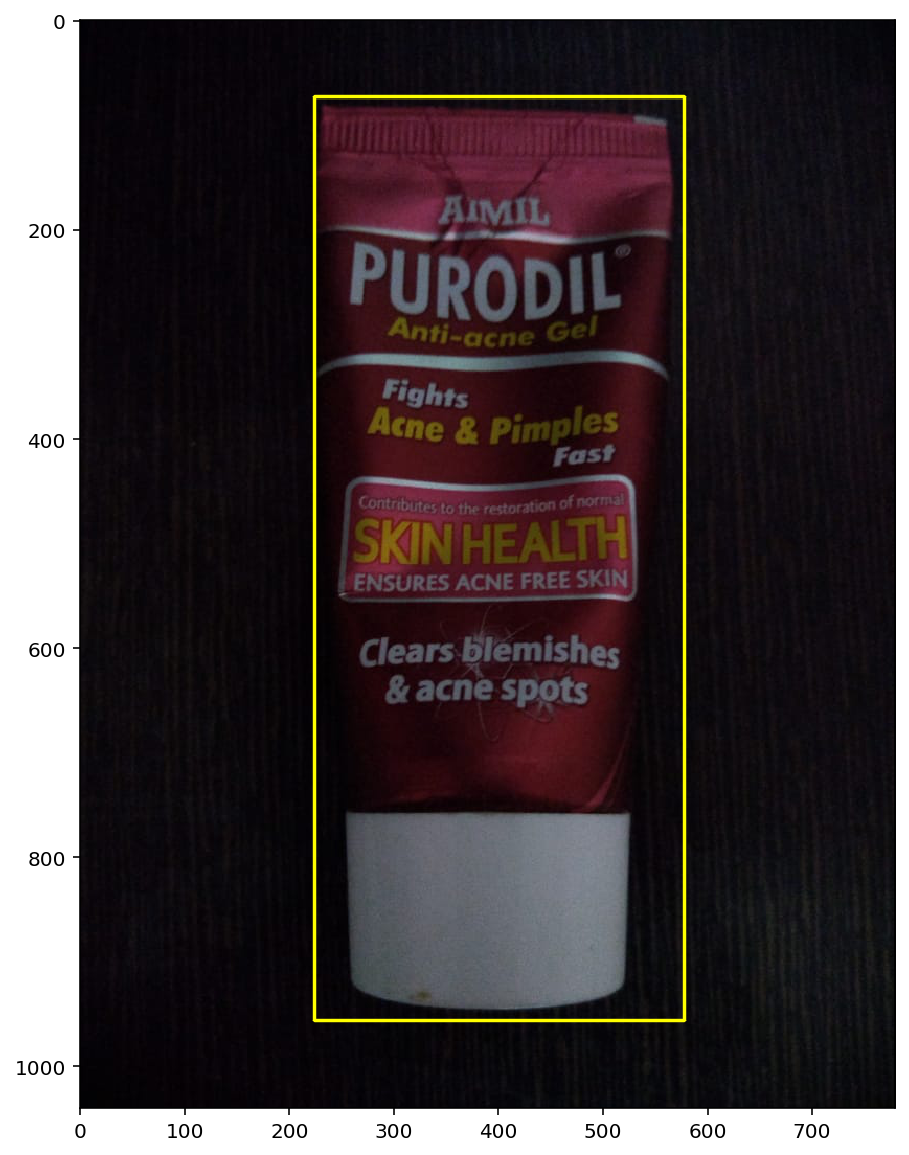

In [0]:
show_img(df.iloc[3])

PREPROCESSING


In [0]:
train_df , test_df = train_test_split(df , test_size = 0.25 , random_state = RANDOM_SEED)

In [0]:
train_df

,img_name,x_min,y_min,x_max,y_max,class_name
0,/content/puro/1.jpeg,62,446,336,992,puro
7,/content/puro/8.jpeg,206,511,392,920,puro
2,/content/puro/3.jpeg,150,420,356,894,puro
4,/content/puro/5.jpeg,230,248,520,958,puro
3,/content/puro/4.jpeg,224,73,577,956,puro
6,/content/puro/7.jpeg,223,371,396,745,puro


In [0]:
train_df.to_csv("annotations.csv" , index=False , header = None)

In [0]:
train_df

,img_name,x_min,y_min,x_max,y_max,class_name
0,/content/puro/1.jpeg,62,446,336,992,puro
7,/content/puro/8.jpeg,206,511,392,920,puro
2,/content/puro/3.jpeg,150,420,356,894,puro
4,/content/puro/5.jpeg,230,248,520,958,puro
3,/content/puro/4.jpeg,224,73,577,956,puro
6,/content/puro/7.jpeg,223,371,396,745,puro


In [0]:
classes = set(["puro"])

with open("classes.csv" , 'w') as f:
  for i , line in enumerate(sorted(classes)):
    f.write('{}, {}\n'.format(line , i))

In [0]:
pd.read_csv("annotations.csv")

,/content/puro/1.jpeg,62,446,336,992,puro
0,/content/puro/8.jpeg,206,511,392,920,puro
1,/content/puro/3.jpeg,150,420,356,894,puro
2,/content/puro/5.jpeg,230,248,520,958,puro
3,/content/puro/4.jpeg,224,73,577,956,puro
4,/content/puro/7.jpeg,223,371,396,745,puro


In [0]:
!head classes.csv

puro, 0


In [0]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

('./snapshots/_pretrained_model.h5',
 <http.client.HTTPMessage at 0x7ff045548da0>)

In [0]:
!keras_retinanet/bin/train.py \
 --freeze-backbone \
 --random-transform \
 --weights {PRETRAINED_MODEL} \
 --batch-size 3 \
 --steps 500 \
 --epochs 10 \
 csv annotations.csv classes.csv

Using TensorFlow backend.
2020-02-22 10:36:54.624708: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-02-22 10:36:54.624798: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-02-22 10:36:54.624814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Creating model, this may take a second...
2020-02-22 10:36:55.591902: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORC

In [0]:
!ls snapshots

_pretrained_model.h5  resnet50_csv_04.h5  resnet50_csv_08.h5
resnet50_csv_01.h5    resnet50_csv_05.h5  resnet50_csv_09.h5
resnet50_csv_02.h5    resnet50_csv_06.h5  resnet50_csv_10.h5
resnet50_csv_03.h5    resnet50_csv_07.h5


In [0]:
model_path = "snapshots/resnet50_csv_10.h5" 

In [0]:
model = models.load_model(model_path , backbone_name="resnet50")

In [0]:
model = models.convert_model(model)

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

In [0]:
label_dict = pd.read_csv("classes.csv" , header=None).T.loc[0].to_dict()

In [0]:
label_dict

{0: 'puro'}

In [0]:
def show_detection(test_df):
  img_path = test_df.img_name
  box_org = [test_df.x_min , test_df.y_min , test_df.x_max , test_df.y_max]
  image = read_image_bgr(img_path)
  draw = image.copy()
  draw = cv2.cvtColor(draw , cv2.COLOR_BGR2RGB)
  
  image = preprocess_image(image)
  image , scale = resize_image(image)

  box_pred , score , label = model.predict_on_batch(np.expand_dims(image , axis=0))
  box_pred /= scale
  draw_box(draw , box_org , (0,0,0))
  box_pred = box_pred.astype(int)
  draw_box(draw , box_pred[0][0] , (255,255,255))
  caption = "{} {}".format(labels_to_name[label[0][0]] , str(score[0][0]))
  #print(labels_to_name[label[0][0]])
  #print(box_pred)
  box_pred = np.array(box_pred).astype(int)
  cv2.putText(draw, caption, (box_pred[0][0][0], box_pred[0][0][1] - 10), cv2.FONT_HERSHEY_PLAIN, 3, (0, 0, 0), 2)
  plt.imshow(draw)
  plt.show()

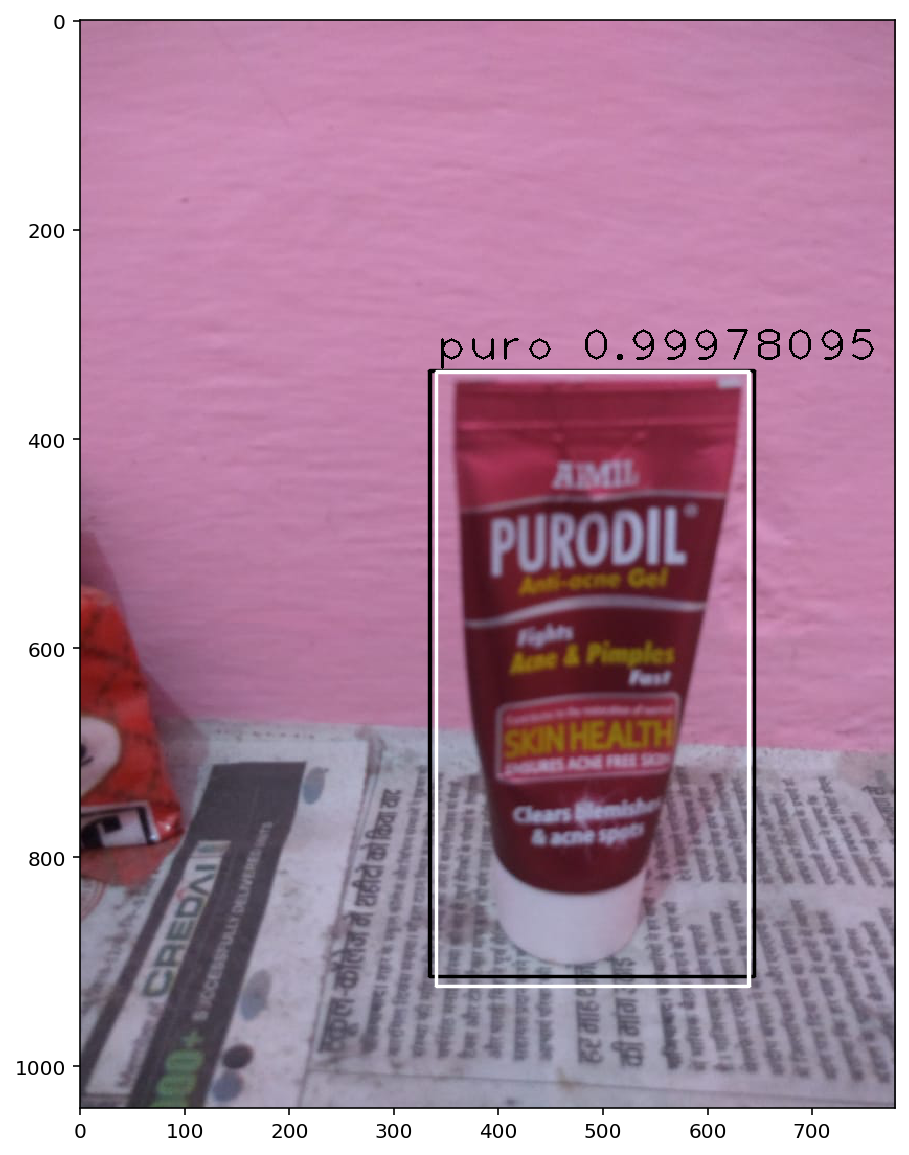

In [0]:
show_detection(test_df.iloc[0])